In [1]:
from pathlib import Path

import numpy as np
import jax
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI
from jaxpower import (compute_mesh_power, PowerSpectrumMultipoles, generate_gaussian_mesh, generate_anisotropic_gaussian_mesh, generate_uniform_particles, RealMeshField, ParticleField, FKPField,
                      compute_fkp_power, BinnedStatistic, WindowMatrix, MeshAttrs, BinAttrs, compute_mean_mesh_power, compute_mesh_window, compute_normalization, utils, create_sharding_mesh, make_particles_from_local, create_sharded_array, create_sharded_random, compute_fkp_normalization_and_shotnoise)

attrs = MeshAttrs(meshsize=(128,) * 3, boxsize=1000., boxcenter=1200.)
size = int(1e-3 * attrs.boxsize.prod())
data = generate_uniform_particles(attrs, size + 1, seed=42)
randoms = generate_uniform_particles(attrs, 4 * size + 1, seed=43)

cosmo = DESI()
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)

f, b = 0.8, 1.5
beta = f / b
kinedges = np.linspace(0.001, 0.7, 100)
kin = (kinedges[:-1] + kinedges[1:]) / 2.
ells = (0, 2, 4)
poles = jnp.array([(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk(kin),
                    0.9 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pk(kin),
                    8. / 35 * beta ** 2 * pk(kin)])
theory = BinnedStatistic(x=[kin] * len(ells), edges=[kinedges] * len(ells), value=poles, projs=ells)
mesh = generate_anisotropic_gaussian_mesh(attrs, theory, seed=random.key(42), los='local', unitary_amplitude=True)
data = data.clone(weights=1. + mesh.read(data.positions))

In [2]:
fkp = FKPField(data, randoms, **attrs.clone(boxsize=2. * attrs.boxsize))  # x2 padding
norm, shotnoise_nonorm = compute_fkp_normalization_and_shotnoise(fkp)
#mesh = fkp.paint(resampler='tsc', interlacing=0, compensate=False, out='real')
mesh = fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
bin = BinAttrs(mesh.attrs, edges={'step': 0.01})
poles = compute_mesh_power(mesh, bin=bin, ells=(0, 2, 4), los='firstpoint').clone(norm=norm, shotnoise_nonorm=shotnoise_nonorm)

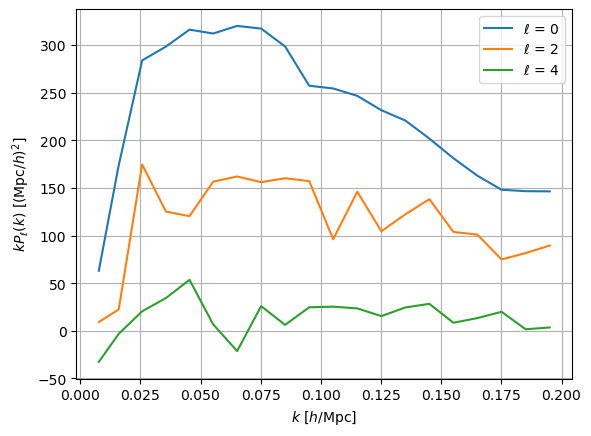

In [3]:
poles.plot(show=True);

In [4]:
list_poles = {}
edges = {'step': 0.01}

compute = jax.jit(compute_mesh_power, static_argnames=['ells', 'los'])

for level, nsplits in enumerate([1, 2]):
    bin = None
    list_poles[level] = []
    for split_fkp in fkp.clone(meshsize=attrs.meshsize // 2).split(nsplits=nsplits):
        split_norm, split_shotnoise_nonorm = compute_fkp_normalization_and_shotnoise(split_fkp)
        mesh = split_fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
        # Compute mesh power spectrum
        if bin is None: bin = BinAttrs(mesh.attrs, edges=edges)
        split_poles = compute(mesh, bin=bin, ells=(0, 2, 4), los='firstpoint').clone(norm=split_norm, shotnoise_nonorm=split_shotnoise_nonorm)
        list_poles[level].append(split_poles)

In [5]:
fnyq = 0.8
split_poles = []
for level in list_poles:
    kmin = 0
    kmax = np.inf
    if level < len(list_poles) - 1: kmax = fnyq * list_poles[level][0].edges(projs=0).max()
    if split_poles: kmin = split_poles[-1].edges(projs=0).max()
    split_poles.append(list_poles[0][0].sum([poles.select(xlim=(kmin, kmax)) for poles in list_poles[level]]))
split_poles = split_poles[0].concatenate(split_poles)

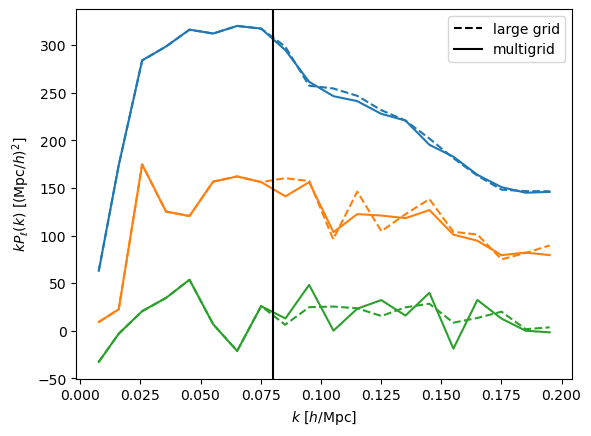

In [6]:
ax = plt.gca()
for iproj, proj in enumerate(poles.projs):
    color = 'C{:d}'.format(iproj)
    k = poles.x(projs=proj)
    ax.plot(k, k * poles.view(projs=proj).real, linestyle='--', color=color)
    k = split_poles.x(projs=proj)
    ax.plot(k, k * split_poles.view(projs=proj).real, linestyle='-', color=color)
ax.plot([], [], color='k', linestyle='--', label='large grid')
ax.plot([], [], color='k', linestyle='-', label='multigrid')
ax.axvline(x=list_poles[0][0].edges(projs=0)[-1] * fnyq, color='k')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend()
plt.show()